# <center> Using balanced batched through model training</center>

In this notebook, we will see how using balanced batches affects the model's performance. 

In [205]:
clear all

In [206]:
# Import import required packages

import pandas as pd
import numpy as np
from sklearn.compose       import ColumnTransformer
from sklearn.pipeline      import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute        import SimpleImputer


In [207]:
# Read CSV file into a dataframe
df=pd.read_csv('dataset/train.csv')

In [208]:
df.shape   # The dataset consists of 614 records/examples, which makes it a small  one

(614, 13)

In [209]:
# Let us view the first 5 rows/records of the data
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Let us heck the data types of the predictors. Note that the columns of type object refers to categorical predictors while others of type int 64 and float 64 are numerical predictors

In [210]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [211]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Class distribution

The target/dependent variable is Loan_Status. its distribution is plotted below as piechart

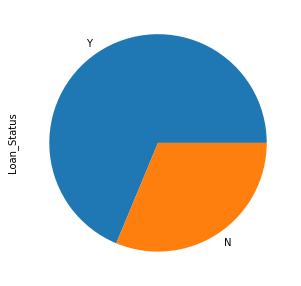

In [212]:
df['Loan_Status'].value_counts().plot.pie(y='Loan_Status',figsize=(5, 5))

The figure above shows that the number of customers with rejected application is much less (less than a half) than the number of custormers with  granted loan, which means that the data is imbalanced.
What about making the data balanced by duplicating the minority class examples i.e, using random oversampling? Shall we upsample our data now? 

No because firstly, we need to clean the data and secondly, upsampling the data before splitting it into training and validation sets would cause data leakage (see SMOTE() below)  

In [214]:
# Counting missing values for each columns
df.isnull().sum(axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### The total number of missing values

In [215]:
df.isnull().sum(axis=0).sum()

149

There several methods which are commonly used to handle missing values in a dataset. At the moment, we will use the simplest one which removes the records/rows with null values from the data. Other methods will be presented and used in the next notebooks.

Can we drop rows with missing values before splitting dataset into training and validation folds? 

Yes, we can as this would not lead to data leakage. 

In [216]:
df=df.dropna()  

In [217]:
df.shape

(480, 13)

The number of rows, after rows with missing values are removed, is equal to 480 which is greater than (614-149). This is because some rows have more than one missing values. 

#### Remove the 'Loan_ID' column
The loan_Id predictor is uninformative predictor so it will removed. 

In [218]:
df=df.drop('Loan_ID', axis=1)

The dataframe of indepoendent variables/predictors can be created by removing the dependent variable

In [219]:
X=df.drop('Loan_Status', axis=1)

In [220]:
# Convert all numerical predictors into float43
def convert_float64(x):
    return x.astype(np.float64)

In [221]:
# Numerical columns
numerical_cols=X.select_dtypes(include=np.number).columns.tolist()

# Numerical p[ipeline
numerical_pipeline=make_pipeline(FunctionTransformer(func=convert_float64, validate=False),
    StandardScaler())

# Categorical columns
categorical_cols=X.select_dtypes(include='object').columns.tolist()


# Categorical pipeline
categorical_pipeline = make_pipeline(OneHotEncoder(categories='auto', drop='first'))

In [222]:
df[categorical_cols].describe()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
count,480,480,480,480,480,480
unique,2,2,4,2,2,3
top,Male,Yes,0,Graduate,No,Semiurban
freq,394,311,274,383,414,191


In [223]:
preprocessor1 = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_cols),
     ('categorical_preprocessing', categorical_pipeline, categorical_cols)],
     remainder='drop')

In [224]:
ss=StandardScaler()
ss_fit=ss.fit(df[numerical_cols])

In [225]:
ss_fit.mean_

array([5.36423125e+03, 1.58109358e+03, 1.44735417e+02, 3.42050000e+02,
       8.54166667e-01])

In [226]:
df[numerical_cols].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


In [255]:
LE=OneHotEncoder(drop='first')
LE_fit=LE.fit(X[categorical_cols])
LE_fit.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['0', '1', '2', '3+'], dtype=object),
 array(['Graduate', 'Not Graduate'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Rural', 'Semiurban', 'Urban'], dtype=object)]

In [276]:
d=dict(zip(categorical_cols,np.array(['Male', 'Yes', '3+', 'Graduate', 'Yes', 'Urban']).reshape(-1,1)))

In [277]:
d

{'Gender': array(['Male'], dtype='<U8'),
 'Married': array(['Yes'], dtype='<U8'),
 'Dependents': array(['3+'], dtype='<U8'),
 'Education': array(['Graduate'], dtype='<U8'),
 'Self_Employed': array(['Yes'], dtype='<U8'),
 'Property_Area': array(['Urban'], dtype='<U8')}

In [278]:
dd=pd.DataFrame(d)

In [280]:
LE_fit.transform(dd).toarray()

array([[1., 1., 0., 0., 1., 0., 1., 0., 1.]])

In [275]:
y=df['Loan_Status']

In [18]:
y=y.replace(['Y','N'],[1,0]).astype(int)

In [19]:
y.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

# Building the model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import initializers

def build_model(input_size):
    model=Sequential()
    
    #KI= initializers.RandomNormal(0.0,0.05)
    KI= initializers.GlorotNormal()  #  Xavier normal initializer.
    BI= initializers.zeros()
    
    model.add(Dense(100, activation='relu', name='layer1', kernel_initializer=KI,bias_initializer=BI,input_dim=input_size))
    
    #model.add(BatchNormalization())

    model.add(Dense(200, activation='relu', name='layer2', kernel_initializer=KI,bias_initializer=BI))

    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))

    model.add(Dense(10, activation='relu', name='layer3', kernel_initializer=KI,bias_initializer=BI))

    model.add(Dense(1,name='layer4', kernel_initializer=KI,bias_initializer=BI))
    # 1- Categorical Classification: The number of neurons in the output layer is exactly the same as the number of classes (2,..)
    # the Softmax function is used to conver logits to probability

    #loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # 2- Binary Classification: The output layer has only one neuron 
    # and the Sigmoid function is used to conver logits to probability
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True) 
    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
    return model
 

To ensure that the target variable of each batch extracted from the training folds is evenly distributed (balanced), BalancedBatchGenerator() is used. 

In [21]:
from sklearn.metrics import roc_auc_score
from imblearn.keras import BalancedBatchGenerator

def fit_predict_with_balanced_batches(X_train, y_train, X_test, y_test):
    model = build_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train,batch_size=32)
    model.fit_generator(generator=training_generator, epochs=10, verbose=2)

    #model.fit(X_train, y_train, epochs=25, verbose=1, batch_size=32)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred)


def fit_predict(X_train, y_train, X_test, y_test):
    model = build_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=25, verbose=2, batch_size=32)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred)


In [22]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

def Accuracy(X,y, balanced_batch=True):
    Accuracy=[]
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_idx, valid_idx in skf.split(X, y):
        X_local_train = preprocessor1.fit_transform(X.iloc[train_idx])
        y_local_train = y.iloc[train_idx].values.ravel()
       
        X_local_test = preprocessor1.transform(X.iloc[valid_idx])
        y_local_test = y.iloc[valid_idx].values.ravel()
        
        if balanced_batch:
            roc_auc = fit_predict_with_balanced_batches(X_local_train, y_local_train, X_local_test, y_local_test)
        else: 
            roc_auc = fit_predict(X_local_train, y_local_train, X_local_test, y_local_test)

        Accuracy.append(roc_auc)
        
    return Accuracy
        
    

In [23]:
# Model training and cross validation

Accuracy_no_balanced_batches=Accuracy(X,y, False) # Original data


Epoch 1/25
14/14 - 0s - loss: 0.6239 - accuracy: 0.5093
Epoch 2/25
14/14 - 0s - loss: 0.5094 - accuracy: 0.8171
Epoch 3/25
14/14 - 0s - loss: 0.4559 - accuracy: 0.8264
Epoch 4/25
14/14 - 0s - loss: 0.4241 - accuracy: 0.8380
Epoch 5/25
14/14 - 0s - loss: 0.4107 - accuracy: 0.8380
Epoch 6/25
14/14 - 0s - loss: 0.3989 - accuracy: 0.8310
Epoch 7/25
14/14 - 0s - loss: 0.3979 - accuracy: 0.8264
Epoch 8/25
14/14 - 0s - loss: 0.3800 - accuracy: 0.8426
Epoch 9/25
14/14 - 0s - loss: 0.3746 - accuracy: 0.8472
Epoch 10/25
14/14 - 0s - loss: 0.3665 - accuracy: 0.8495
Epoch 11/25
14/14 - 0s - loss: 0.3577 - accuracy: 0.8495
Epoch 12/25
14/14 - 0s - loss: 0.3507 - accuracy: 0.8495
Epoch 13/25
14/14 - 0s - loss: 0.3429 - accuracy: 0.8611
Epoch 14/25
14/14 - 0s - loss: 0.3355 - accuracy: 0.8634
Epoch 15/25
14/14 - 0s - loss: 0.3280 - accuracy: 0.8681
Epoch 16/25
14/14 - 0s - loss: 0.3301 - accuracy: 0.8681
Epoch 17/25
14/14 - 0s - loss: 0.3158 - accuracy: 0.8634
Epoch 18/25
14/14 - 0s - loss: 0.3102 - 

Epoch 1/25
14/14 - 0s - loss: 0.6340 - accuracy: 0.4236
Epoch 2/25
14/14 - 0s - loss: 0.5145 - accuracy: 0.8194
Epoch 3/25
14/14 - 0s - loss: 0.4669 - accuracy: 0.8148
Epoch 4/25
14/14 - 0s - loss: 0.4429 - accuracy: 0.8264
Epoch 5/25
14/14 - 0s - loss: 0.4239 - accuracy: 0.8264
Epoch 6/25
14/14 - 0s - loss: 0.4112 - accuracy: 0.8333
Epoch 7/25
14/14 - 0s - loss: 0.4076 - accuracy: 0.8449
Epoch 8/25
14/14 - 0s - loss: 0.3938 - accuracy: 0.8194
Epoch 9/25
14/14 - 0s - loss: 0.3939 - accuracy: 0.8449
Epoch 10/25
14/14 - 0s - loss: 0.3787 - accuracy: 0.8472
Epoch 11/25
14/14 - 0s - loss: 0.3712 - accuracy: 0.8495
Epoch 12/25
14/14 - 0s - loss: 0.3641 - accuracy: 0.8519
Epoch 13/25
14/14 - 0s - loss: 0.3605 - accuracy: 0.8542
Epoch 14/25
14/14 - 0s - loss: 0.3516 - accuracy: 0.8588
Epoch 15/25
14/14 - 0s - loss: 0.3487 - accuracy: 0.8519
Epoch 16/25
14/14 - 0s - loss: 0.3438 - accuracy: 0.8704
Epoch 17/25
14/14 - 0s - loss: 0.3315 - accuracy: 0.8727
Epoch 18/25
14/14 - 0s - loss: 0.3252 - 

Epoch 19/25
14/14 - 0s - loss: 0.3389 - accuracy: 0.8704
Epoch 20/25
14/14 - 0s - loss: 0.3381 - accuracy: 0.8657
Epoch 21/25
14/14 - 0s - loss: 0.3299 - accuracy: 0.8704
Epoch 22/25
14/14 - 0s - loss: 0.3148 - accuracy: 0.8843
Epoch 23/25
14/14 - 0s - loss: 0.3130 - accuracy: 0.8750
Epoch 24/25
14/14 - 0s - loss: 0.3031 - accuracy: 0.8727
Epoch 25/25
14/14 - 0s - loss: 0.2973 - accuracy: 0.8866
Epoch 1/25
14/14 - 0s - loss: 0.5790 - accuracy: 0.6458
Epoch 2/25
14/14 - 0s - loss: 0.4815 - accuracy: 0.8171
Epoch 3/25
14/14 - 0s - loss: 0.4483 - accuracy: 0.8241
Epoch 4/25
14/14 - 0s - loss: 0.4307 - accuracy: 0.8333
Epoch 5/25
14/14 - 0s - loss: 0.4219 - accuracy: 0.8056
Epoch 6/25
14/14 - 0s - loss: 0.4117 - accuracy: 0.8218
Epoch 7/25
14/14 - 0s - loss: 0.3989 - accuracy: 0.8241
Epoch 8/25
14/14 - 0s - loss: 0.3964 - accuracy: 0.8426
Epoch 9/25
14/14 - 0s - loss: 0.3870 - accuracy: 0.8171
Epoch 10/25
14/14 - 0s - loss: 0.3763 - accuracy: 0.8495
Epoch 11/25
14/14 - 0s - loss: 0.3735 - 

In [24]:
Accuracy_balanced_batch=Accuracy(X,y,True)   

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
8/8 - 0s - loss: 0.6338 - accuracy: 0.4961
Epoch 2/10
8/8 - 0s - loss: 0.5424 - accuracy: 0.6484
Epoch 3/10
8/8 - 0s - loss: 0.5043 - accuracy: 0.7188
Epoch 4/10
8/8 - 0s - loss: 0.4873 - accuracy: 0.7461
Epoch 5/10
8/8 - 0s - loss: 0.4732 - accuracy: 0.7539
Epoch 6/10
8/8 - 0s - loss: 0.4588 - accuracy: 0.7695
Epoch 7/10
8/8 - 0s - loss: 0.4483 - accuracy: 0.7734
Epoch 8/10
8/8 - 0s - loss: 0.4398 - accuracy: 0.7422
Epoch 9/10
8/8 - 0s - loss: 0.4255 - accuracy: 0.7812
Epoch 10/10
8/8 - 0s - loss: 0.4204 - accuracy: 0.7930
Epoch 1/10
8/8 - 0s - loss: 0.6630 - accuracy: 0.5117
Epoch 2/10
8/8 - 0s - loss: 0.5955 - accuracy: 0.5117
Epoch 3/10
8/8 - 0s - loss: 0.5543 - accuracy: 0.5117
Epoch 4/10
8/8 - 0s - loss: 0.5265 - accuracy: 0.5312
Epoch 5/10
8/8 - 0s - loss: 0.5124 - accuracy: 0.6328
Epoch 6/10
8/8 - 0s - loss: 0.4985 - accuracy: 0.7148
Epoch 7/10
8/8 - 0s - loss: 0.4868 - accuracy: 0.7617
Epoch

Epoch 1/10
8/8 - 0s - loss: 0.6747 - accuracy: 0.5117
Epoch 2/10
8/8 - 0s - loss: 0.6218 - accuracy: 0.6719
Epoch 3/10
8/8 - 0s - loss: 0.5815 - accuracy: 0.6953
Epoch 4/10
8/8 - 0s - loss: 0.5439 - accuracy: 0.7227
Epoch 5/10
8/8 - 0s - loss: 0.5118 - accuracy: 0.7031
Epoch 6/10
8/8 - 0s - loss: 0.4879 - accuracy: 0.7383
Epoch 7/10
8/8 - 0s - loss: 0.4690 - accuracy: 0.7344
Epoch 8/10
8/8 - 0s - loss: 0.4494 - accuracy: 0.7500
Epoch 9/10
8/8 - 0s - loss: 0.4345 - accuracy: 0.7969
Epoch 10/10
8/8 - 0s - loss: 0.4246 - accuracy: 0.7578
Epoch 1/10
8/8 - 0s - loss: 0.6879 - accuracy: 0.5039
Epoch 2/10
8/8 - 0s - loss: 0.6270 - accuracy: 0.5781
Epoch 3/10
8/8 - 0s - loss: 0.5764 - accuracy: 0.6484
Epoch 4/10
8/8 - 0s - loss: 0.5338 - accuracy: 0.6992
Epoch 5/10
8/8 - 0s - loss: 0.5095 - accuracy: 0.7070
Epoch 6/10
8/8 - 0s - loss: 0.4953 - accuracy: 0.7266
Epoch 7/10
8/8 - 0s - loss: 0.4850 - accuracy: 0.7344
Epoch 8/10
8/8 - 0s - loss: 0.4787 - accuracy: 0.7539
Epoch 9/10
8/8 - 0s - loss:

In [25]:
d={'Accyracy_without_balanced_batches': Accuracy_no_balanced_batches , 'Accuracy_balanced_batch':Accuracy_balanced_batch}
df_results=pd.DataFrame(d)

In [26]:
df_results

,Accyracy_without_balanced_batches,Accuracy_balanced_batch
0,0.587879,0.733333
1,0.795960,0.761616
2,0.878788,0.820202
3,0.727273,0.791919
4,0.761616,0.814141
5,0.616162,0.919192
6,0.793939,0.753535
7,0.765657,0.773737
8,0.640756,0.611345
9,0.512605,0.712185


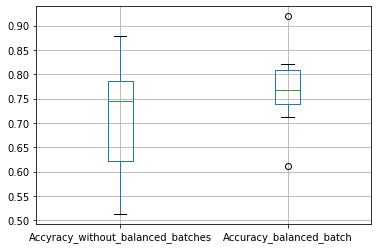

In [27]:
df_results.boxplot()

### Conclusion

The chart shows that generating balanced batchesfrom the training folds improves the model's performance even though the data size is small